In [1]:
import numpy as np
import pandas as pd

from itertools import groupby
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import f1_score, accuracy_score
from pandas.api.types import is_datetime64_ns_dtype

import lightgbm as lgb
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
import gc

import warnings
warnings.filterwarnings("ignore")

In [2]:
TRAIN_PATH='/kaggle/input/zzzs-lightweight-training-dataset-target/Zzzs_train.parquet'

We are using this lighweight data to study the affect of features on one another.

## Loading the dataset

In [3]:
train_data=pd.read_parquet(TRAIN_PATH)

In [4]:
train_data.head()

,series_id,step,timestamp,anglez,enmo,awake
0,08db4255286f,0,2018-11-05T10:00:00-0400,-30.845301,0.0447,1
1,08db4255286f,1,2018-11-05T10:00:05-0400,-34.181801,0.0443,1
2,08db4255286f,2,2018-11-05T10:00:10-0400,-33.877102,0.0483,1
3,08db4255286f,3,2018-11-05T10:00:15-0400,-34.282101,0.0680,1
4,08db4255286f,4,2018-11-05T10:00:20-0400,-34.385799,0.0768,1


In [5]:
series_id  = pd.read_parquet(TRAIN_PATH, columns=['series_id'])
series_id = series_id['series_id'].unique()

weird_series = ['31011ade7c0a', 'a596ad0b82aa']
series_id = [s for s in series_id if s not in weird_series]

In [6]:
def basic_fe(df, periods):
    
    df['series_id'] = df['series_id'].astype('category')
    df['timestamp'] = pd.to_datetime(df['timestamp']).apply(lambda t: t.tz_localize(None))
    df['hour'] = df["timestamp"].dt.hour
    
    df.sort_values(['timestamp'], inplace=True)
    df.set_index('timestamp', inplace=True)
    
    df['lids'] = np.maximum(0., df['enmo'] - 0.02)
    df['lids'] = df['lids'].rolling(f'{120*5}s', center=True, min_periods=1).agg('sum')
    df['lids'] = 100 / (df['lids'] + 1)
    df['lids'] = df['lids'].rolling(f'{360*5}s', center=True, min_periods=1).agg('mean').astype(np.float16)
    
    df["enmo"] = (df["enmo"]*1000).astype(np.int16)
    df["anglez"] = df["anglez"].astype(np.int16)
    df["anglezdiffabs"] = df["anglez"].diff().abs().astype(np.float16)
    
    for col in ['enmo', 'anglez', 'anglezdiffabs']:
        for p in periods:
            rol_args = {'window':f'{p+5}s', 'min_periods':10, 'center':True}
            
            for agg in ['mean', 'max', 'min']:
                df[f'{col}_{p}_{agg}'] = df[col].rolling(**rol_args).agg(agg).astype(np.float16).values
                gc.collect()
            # There was an overflow error when trying to cast to float16, so I decided to leave it as float32
            for agg in ['var']:
                df[f'{col}_{p}_{agg}'] = df[col].rolling(**rol_args).agg(agg).astype(np.float32).values
                gc.collect()

            
            df[f'{col}_{p}_amplit'] = df[f'{col}_{p}_max'] - df[f'{col}_{p}_min']
            df[f'{col}_diff_{p}_max'] = df[f'{col}_{p}_max'].diff().abs().rolling(**rol_args).max().astype(np.float16)
            df[f'{col}_diff_{p}_mean'] = df[f'{col}_{p}_min'].diff().abs().rolling(**rol_args).mean().astype(np.float16)
            gc.collect()
 
    df.reset_index(inplace=True)
    df.dropna(inplace=True)
    gc.collect()

    return df

In [7]:
def feat_eng_by_id(idx, periods):
    
    from warnings import simplefilter 
    simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
    
    df = pd.read_parquet(TRAIN_PATH, filters=[('series_id','=',idx)])
    df['awake'] = df['awake'].astype(np.int8)
    df = basic_fe(df, periods)
    
    return df

In [8]:
periods = [60, 300, 600, 3600] 

In [9]:
%%time

df = Parallel(n_jobs=-2)(delayed(feat_eng_by_id)(i, periods) for i in series_id)
df = pd.concat(df, ignore_index=True)

CPU times: user 6.19 s, sys: 10.2 s, total: 16.4 s
Wall time: 3min 54s


In [10]:
pip install fasteda

  Preparing metadata (setup.py) ... done
  Created wheel for fasteda: filename=fasteda-1.0.1-py3-none-any.whl size=4723 sha256=18ec1a2c82c94c39de9226389c4b0684b332d18959643061d3b3a9102ab80087
  Stored in directory: /root/.cache/pip/wheels/ed/08/72/0d0ec0d3927d227b38ce9542ec3fa6b975c2e17ad0d046dcee
Successfully built fasteda
Note: you may need to restart the kernel to use updated packages.


In [11]:
from fasteda import fast_eda

In [12]:
df

,timestamp,series_id,step,anglez,enmo,awake,hour,lids,anglezdiffabs,enmo_60_mean,enmo_60_max,enmo_60_min,enmo_60_var,enmo_60_amplit,enmo_diff_60_max,enmo_diff_60_mean,enmo_300_mean,enmo_300_max,enmo_300_min,enmo_300_var,enmo_300_amplit,enmo_diff_300_max,enmo_diff_300_mean,enmo_600_mean,enmo_600_max,enmo_600_min,enmo_600_var,enmo_600_amplit,enmo_diff_600_max,enmo_diff_600_mean,enmo_3600_mean,enmo_3600_max,enmo_3600_min,enmo_3600_var,enmo_3600_amplit,enmo_diff_3600_max,enmo_diff_3600_mean,anglez_60_mean,anglez_60_max,anglez_60_min,anglez_60_var,anglez_60_amplit,anglez_diff_60_max,anglez_diff_60_mean,anglez_300_mean,anglez_300_max,anglez_300_min,anglez_300_var,anglez_300_amplit,anglez_diff_300_max,anglez_diff_300_mean,anglez_600_mean,anglez_600_max,anglez_600_min,anglez_600_var,anglez_600_amplit,anglez_diff_600_max,anglez_diff_600_mean,anglez_3600_mean,anglez_3600_max,anglez_3600_min,anglez_3600_var,anglez_3600_amplit,anglez_diff_3600_max,anglez_diff_3600_mean,anglezdiffabs_60_mean,anglezdiffabs_60_max,anglezdiffabs_60_min,anglezdiffabs_60_var,anglezdiffabs_60_amplit,anglezdiffabs_diff_60_max,anglezdiffabs_diff_60_mean,anglezdiffabs_300_mean,anglezdiffabs_300_max,anglezdiffabs_300_min,anglezdiffabs_300_var,anglezdiffabs_300_amplit,anglezdiffabs_diff_300_max,anglezdiffabs_diff_300_mean,anglezdiffabs_600_mean,anglezdiffabs_600_max,anglezdiffabs_600_min,anglezdiffabs_600_var,anglezdiffabs_600_amplit,anglezdiffabs_diff_600_max,anglezdiffabs_diff_600_mean,anglezdiffabs_3600_mean,anglezdiffabs_3600_max,anglezdiffabs_3600_min,anglezdiffabs_3600_var,anglezdiffabs_3600_amplit,anglezdiffabs_diff_3600_max,anglezdiffabs_diff_3600_mean
0,2018-11-05 10:00:40,08db4255286f,8,-32,48,1,10,14.109375,2.0,63.15625,107.0,46.0,303.307678,61.0,28.0,0.727051,59.96875,107.0,40.0,197.394058,67.0,66.0,0.368408,74.3750,198.0,26.0,1099.888794,172.0,0.0,0.205933,75.1875,198.0,22.0,963.100281,176.0,0.0,0.0,-31.531250,-28.0,-34.0,4.769231,6.0,4.0,0.000000,-28.234375,-18.0,-34.0,16.866396,16.0,0.0,0.000000,-27.406250,-18.0,-34.0,13.391730,16.0,0.0,0.014709,-27.343750,-16.0,-36.0,14.234594,20.0,0.0,0.008156,1.307617,4.0,0.0,1.230769,4.0,1.0,0.0,1.920898,6.0,0.0,2.885491,6.0,0.0,0.0,1.706055,6.0,0.0,2.419666,6.0,4.0,0.0,1.856445,10.0,0.0,2.510536,10.0,0.0,0.0
1,2018-11-05 10:00:45,08db4255286f,9,-34,46,1,10,14.101562,2.0,62.53125,107.0,40.0,328.435883,67.0,28.0,0.666504,60.15625,107.0,40.0,193.566666,67.0,66.0,0.358887,74.6875,198.0,26.0,1089.441162,172.0,0.0,0.202881,75.1250,198.0,22.0,961.483826,176.0,0.0,0.0,-30.843750,-24.0,-34.0,8.807693,10.0,4.0,0.000000,-28.296875,-18.0,-34.0,16.625641,16.0,0.0,0.000000,-27.406250,-18.0,-34.0,13.200000,16.0,0.0,0.014496,-27.328125,-16.0,-36.0,14.196323,20.0,0.0,0.008133,1.615234,5.0,0.0,2.256410,5.0,1.0,0.0,1.922852,6.0,0.0,2.809717,6.0,0.0,0.0,1.695312,6.0,0.0,2.391304,6.0,4.0,0.0,1.856445,10.0,0.0,2.503771,10.0,0.0,0.0
2,2018-11-05 10:00:50,08db4255286f,10,-32,79,1,10,14.093750,2.0,60.78125,107.0,40.0,348.192322,67.0,28.0,0.615234,60.96875,107.0,40.0,216.674393,67.0,66.0,0.350098,75.6250,198.0,26.0,1139.635376,172.0,0.0,0.199951,75.0625,198.0,22.0,959.218628,176.0,0.0,0.0,-30.312500,-24.0,-34.0,8.897436,10.0,4.0,0.153809,-28.359375,-18.0,-34.0,16.387804,16.0,0.0,0.024994,-27.375000,-18.0,-34.0,13.039034,16.0,0.0,0.014282,-27.328125,-16.0,-36.0,14.172652,20.0,0.0,0.008110,1.769531,5.0,0.0,2.358974,5.0,1.0,0.0,1.875000,6.0,0.0,2.830128,6.0,0.0,0.0,1.685547,6.0,0.0,2.363561,6.0,4.0,0.0,1.856445,10.0,0.0,2.497041,10.0,0.0,0.0
3,2018-11-05 10:00:55,08db4255286f,11,-31,71,1,10,14.078125,1.0,58.00000,107.0,40.0,356.500000,67.0,28.0,0.615234,61.62500,107.0,40.0,228.778168,67.0,66.0,0.341553,76.8125,198.0,26.0,1222.440552,172.0,0.0,0.197144,75.0625,198.0,22.0,957.329163,176.0,0.0,0.0,-29.687500,-24.0,-34.0,8.897436,10.0,4.0,0.230713,-28.406250,-18.0,-34.0,16.051683,16.0,0.0,0.024384,-27.328125,-18.0,-34.0,13.014085,16.0,0.0,0.014084,-27.328125,-16.0,-36.0,14.149031,20.0,0.0,0.008087,1.845703,5.0,0.0,2.141026,5.0,1.0,0.0,1.853516,6.

DataFrame Head:


,step,anglez,enmo,awake,hour,lids,anglezdiffabs,enmo_60_mean,enmo_60_max,enmo_60_min,enmo_60_var,enmo_60_amplit,enmo_diff_60_max,enmo_diff_60_mean,enmo_300_mean,enmo_300_max,enmo_300_min,enmo_300_var,enmo_300_amplit,enmo_diff_300_max,enmo_diff_300_mean,enmo_600_mean,enmo_600_max,enmo_600_min,enmo_600_var,enmo_600_amplit,enmo_diff_600_max,enmo_diff_600_mean,enmo_3600_mean,enmo_3600_max,enmo_3600_min,enmo_3600_var,enmo_3600_amplit,enmo_diff_3600_max,enmo_diff_3600_mean,anglez_60_mean,anglez_60_max,anglez_60_min,anglez_60_var,anglez_60_amplit,anglez_diff_60_max,anglez_diff_60_mean,anglez_300_mean,anglez_300_max,anglez_300_min,anglez_300_var,anglez_300_amplit,anglez_diff_300_max,anglez_diff_300_mean,anglez_600_mean,anglez_600_max,anglez_600_min,anglez_600_var,anglez_600_amplit,anglez_diff_600_max,anglez_diff_600_mean,anglez_3600_mean,anglez_3600_max,anglez_3600_min,anglez_3600_var,anglez_3600_amplit,anglez_diff_3600_max,anglez_diff_3600_mean,anglezdiffabs_60_mean,anglezdiffabs_60_max,anglezdiffabs_60_min,anglezdiffabs_60_var,anglezdiffabs_60_amplit,anglezdiffabs_diff_60_max,anglezdiffabs_diff_60_mean,anglezdiffabs_300_mean,anglezdiffabs_300_max,anglezdiffabs_300_min,anglezdiffabs_300_var,anglezdiffabs_300_amplit,anglezdiffabs_diff_300_max,anglezdiffabs_diff_300_mean,anglezdiffabs_600_mean,anglezdiffabs_600_max,anglezdiffabs_600_min,anglezdiffabs_600_var,anglezdiffabs_600_amplit,anglezdiffabs_diff_600_max,anglezdiffabs_diff_600_mean,anglezdiffabs_3600_mean,anglezdiffabs_3600_max,anglezdiffabs_3600_min,anglezdiffabs_3600_var,anglezdiffabs_3600_amplit,anglezdiffabs_diff_3600_max,anglezdiffabs_diff_3600_mean
0,8,-32,48,1,10,14.109375,2.0,63.15625,107.0,46.0,303.307678,61.0,28.0,0.727051,59.96875,107.0,40.0,197.394058,67.0,66.0,0.368408,74.3750,198.0,26.0,1099.888794,172.0,0.0,0.205933,75.1875,198.0,22.0,963.100281,176.0,0.0,0.0,-31.53125,-28.0,-34.0,4.769231,6.0,4.0,0.000000,-28.234375,-18.0,-34.0,16.866396,16.0,0.0,0.000000,-27.40625,-18.0,-34.0,13.391730,16.0,0.0,0.014709,-27.343750,-16.0,-36.0,14.234594,20.0,0.0,0.008156,1.307617,4.0,0.0,1.230769,4.0,1.0,0.0,1.920898,6.0,0.0,2.885491,6.0,0.0,0.0,1.706055,6.0,0.0,2.419666,6.0,4.0,0.0,1.856445,10.0,0.0,2.510536,10.0,0.0,0.0
1,9,-34,46,1,10,14.101562,2.0,62.53125,107.0,40.0,328.435883,67.0,28.0,0.666504,60.15625,107.0,40.0,193.566666,67.0,66.0,0.358887,74.6875,198.0,26.0,1089.441162,172.0,0.0,0.202881,75.1250,198.0,22.0,961.483826,176.0,0.0,0.0,-30.84375,-24.0,-34.0,8.807693,10.0,4.0,0.000000,-28.296875,-18.0,-34.0,16.625641,16.0,0.0,0.000000,-27.40625,-18.0,-34.0,13.200000,16.0,0.0,0.014496,-27.328125,-16.0,-36.0,14.196323,20.0,0.0,0.008133,1.615234,5.0,0.0,2.256410,5.0,1.0,0.0,1.922852,6.0,0.0,2.809717,6.0,0.0,0.0,1.695312,6.0,0.0,2.391304,6.0,4.0,0.0,1.856445,10.0,0.0,2.503771,10.0,0.0,0.0
2,10,-32,79,1,10,14.093750,2.0,60.78125,107.0,40.0,348.192322,67.0,28.0,0.615234,60.96875,107.0,40.0,216.674393,67.0,66.0,0.350098,75.6250,198.0,26.0,1139.635376,172.0,0.0,0.199951,75.0625,198.0,22.0,959.218628,176.0,0.0,0.0,-30.31250,-24.0,-34.0,8.897436,10.0,4.0,0.153809,-28.359375,-18.0,-34.0,16.387804,16.0,0.0,0.024994,-27.37500,-18.0,-34.0,13.039034,16.0,0.0,0.014282,-27.328125,-16.0,-36.0,14.172652,20.0,0.0,0.008110,1.769531,5.0,0.0,2.358974,5.0,1.0,0.0,1.875000,6.0,0.0,2.830128,6.0,0.0,0.0,1.685547,6.0,0.0,2.363561,6.0,4.0,0.0,1.856445,10.0,0.0,2.497041,10.0,0.0,0.0


DataFrame Tail:


,step,anglez,enmo,awake,hour,lids,anglezdiffabs,enmo_60_mean,enmo_60_max,enmo_60_min,enmo_60_var,enmo_60_amplit,enmo_diff_60_max,enmo_diff_60_mean,enmo_300_mean,enmo_300_max,enmo_300_min,enmo_300_var,enmo_300_amplit,enmo_diff_300_max,enmo_diff_300_mean,enmo_600_mean,enmo_600_max,enmo_600_min,enmo_600_var,enmo_600_amplit,enmo_diff_600_max,enmo_diff_600_mean,enmo_3600_mean,enmo_3600_max,enmo_3600_min,enmo_3600_var,enmo_3600_amplit,enmo_diff_3600_max,enmo_diff_3600_mean,anglez_60_mean,anglez_60_max,anglez_60_min,anglez_60_var,anglez_60_amplit,anglez_diff_60_max,anglez_diff_60_mean,anglez_300_mean,anglez_300_max,anglez_300_min,anglez_300_var,anglez_300_amplit,anglez_diff_300_max,anglez_diff_300_mean,anglez_600_mean,anglez_600_max,anglez_600_min,anglez_600_var,anglez_600_amplit,anglez_diff_600_max,anglez_diff_600_mean,anglez_3600_mean,anglez_3600_max,anglez_3600_min,anglez_3600_var,anglez_3600_amplit,anglez_diff_3600_max,anglez_diff_3600_mean,anglezdiffabs_60_mean,anglezdiffabs_60_max,anglezdiffabs_60_min,anglezdiffabs_60_var,anglezdiffabs_60_amplit,anglezdiffabs_diff_60_max,anglezdiffabs_diff_60_mean,anglezdiffabs_300_mean,anglezdiffabs_300_max,anglezdiffabs_300_min,anglezdiffabs_300_var,anglezdiffabs_300_amplit,anglezdiffabs_diff_300_max,anglezdiffabs_diff_300_mean,anglezdiffabs_600_mean,anglezdiffabs_600_max,anglezdiffabs_600_min,anglezdiffabs_600_var,anglezdiffabs_600_amplit,anglezdiffabs_diff_600_max,anglezdiffabs_diff_600_mean,anglezdiffabs_3600_mean,anglezdiffabs_3600_max,anglezdiffabs_3600_min,anglezdiffabs_3600_var,anglezdiffabs_3600_amplit,anglezdiffabs_diff_3600_max,anglezdiffabs_diff_3600_mean
13165054,395811,-14,66,1,15,13.335938,5.0,106.3125,157.0,57.0,1205.897461,100.0,5.0,0.0,102.6250,174.0,44.0,1172.867798,130.0,17.0,0.0,97.5000,174.0,44.0,1141.724243,130.0,3.0,0.014496,73.6250,222.0,25.0,990.203979,197.0,60.0,0.0,-12.382812,-3.0,-19.0,27.423077,16.0,1.0,0.0,-12.234375,-3.0,-19.0,14.971660,16.0,1.0,0.0,-11.101562,-1.0,-19.0,19.974852,18.0,2.0,0.086975,-6.871094,5.0,-25.0,32.426666,30.0,3.0,0.0,3.460938,10.0,0.0,9.602564,10.0,4.0,0.0,2.460938,10.0,0.0,5.465587,10.0,2.0,0.0,2.710938,10.0,0.0,5.297101,10.0,0.0,0.0,2.707031,11.0,0.0,5.055408,11.0,0.0,0.0
13165055,395812,-19,114,1,15,13.312500,5.0,109.3125,157.0,57.0,1262.397461,100.0,5.0,0.0,103.2500,174.0,44.0,1189.063965,130.0,17.0,0.0,97.6875,174.0,44.0,1155.583862,130.0,3.0,0.014709,73.6250,222.0,25.0,992.843262,197.0,60.0,0.0,-12.382812,-3.0,-19.0,27.423077,16.0,1.0,0.0,-12.210938,-3.0,-19.0,15.359886,16.0,1.0,0.0,-11.046875,-1.0,-19.0,20.042801,18.0,2.0,0.088257,-6.875000,5.0,-25.0,32.512943,30.0,3.0,0.0,3.539062,10.0,0.0,9.269231,10.0,4.0,0.0,2.474609,10.0,0.0,5.607397,10.0,2.0,0.0,2.734375,10.0,0.0,5.331870,10.0,0.0,0.0,2.708984,11.0,0.0,5.067816,11.0,0.0,0.0
13165056,395813,-18,113,1,15,13.289062,1.0,105.2500,157.0,57.0,1101.359009,100.0,5.0,0.0,104.0625,174.0,44.0,1197.663696,130.0,17.0,0.0,98.3125,174.0,44.0,1150.054688,130.0,3.0,0.014923,73.6875,222.0,25.0,995.395508,197.0,60.0,0.0,-12.382812,-3.0,-19.0,27.423077,16.0,1.0,0.0,-12.164062,-3.0,-19.0,15.695195,16.0,1.0,0.0,-10.953125,-1.0,-19.0,19.800995,18.0,2.0,0.089539,-6.871094,5.0,-25.0,32.598309,30.0,3.0,0.0,3.539062,10.0,0.0,9.269231,10.0,4.0,0.0,2.513672,10.0,0.0,5.701201,10.0,2.0,0.0,2.746094,10.0,0.0,5.404342,10.0,0.0,0.0,2.710938,11.0,0.0,5.080285,11.0,0.0,0.0


----------------------------------------------------------------------------------------------------
Missing values:


,0


----------------------------------------------------------------------------------------------------
Shape of DataFrame:

(13165057, 91)

----------------------------------------------------------------------------------------------------
DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13165057 entries, 0 to 13165056
Data columns (total 91 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   step                          uint32 
 1   anglez                        int16  
 2   enmo                          int16  
 3   awake                         int8   
 4   hour                          int32  
 5   lids                          float16
 6   anglezdiffabs                 float16
 7   enmo_60_mean                  float16
 8   enmo_60_max                   float16
 9   enmo_60_min                   float16
 10  enmo_60_var                   float32
 11  enmo_60_amplit                float16
 12  enmo_diff_60_max      

,count,mean,median,std,min,25%,50%,75%,max,skewness,kurtosis
step,13165057,203375.338,195453,127210.361,8,95720,195453,302271,634673,0.347759,-0.560606
anglez,13165057,-9.08,-10,38.462,-90,-38,-10,16,90,0.236316,-0.540964
enmo,13165057,43.682,16,113.681,0,1,16,40,7016,11.073452,222.936807
awake,13165057,0.658,1,0.474,0,0,1,1,1,-0.665272,-1.557413
hour,13165057,11.518,12,6.94,0,5,12,18,23,-0.005896,-1.211647
lids,13165057,nan,42.188,0,1.01,21.109,42.188,86,100,nan,inf
anglezdiffabs,13165057,nan,1,0,0,0,1,8,171,inf,inf
enmo_60_mean,13165057,nan,20.922,nan,0,4,20.922,48.062,6916,nan,nan
enmo_60_max,13165057,nan,45,nan,0,9,45,131,7016,nan,nan
enmo_60_min,13165057,nan,4,nan,0,0,4,16,5940,nan,nan


----------------------------------------------------------------------------------------------------
DataFrame Correlation:



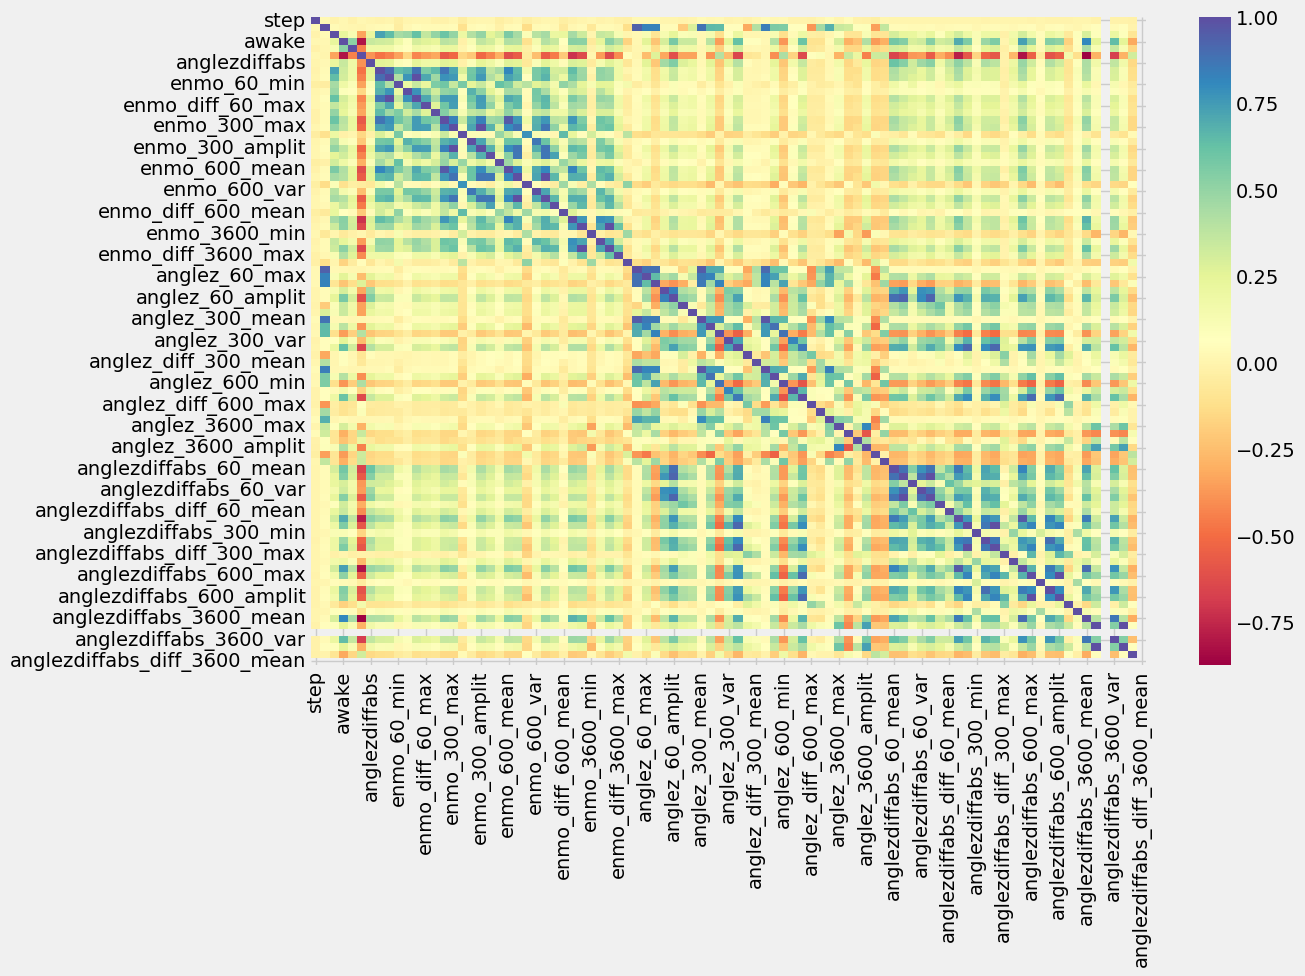

----------------------------------------------------------------------------------------------------
Histogram(s) & Boxplot(s):



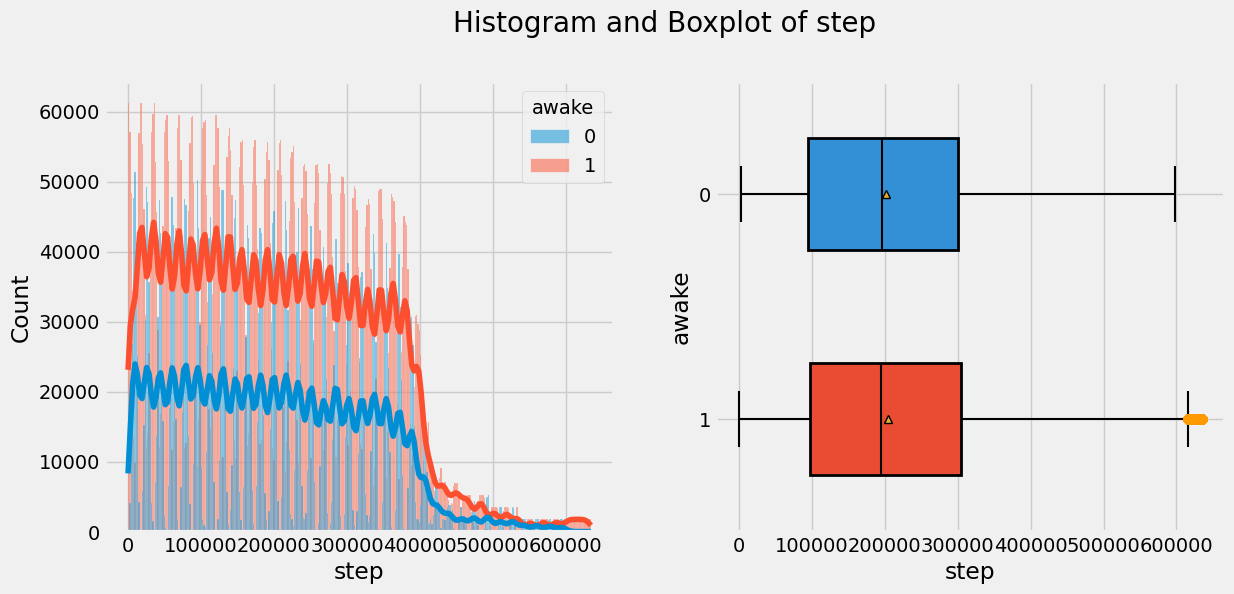

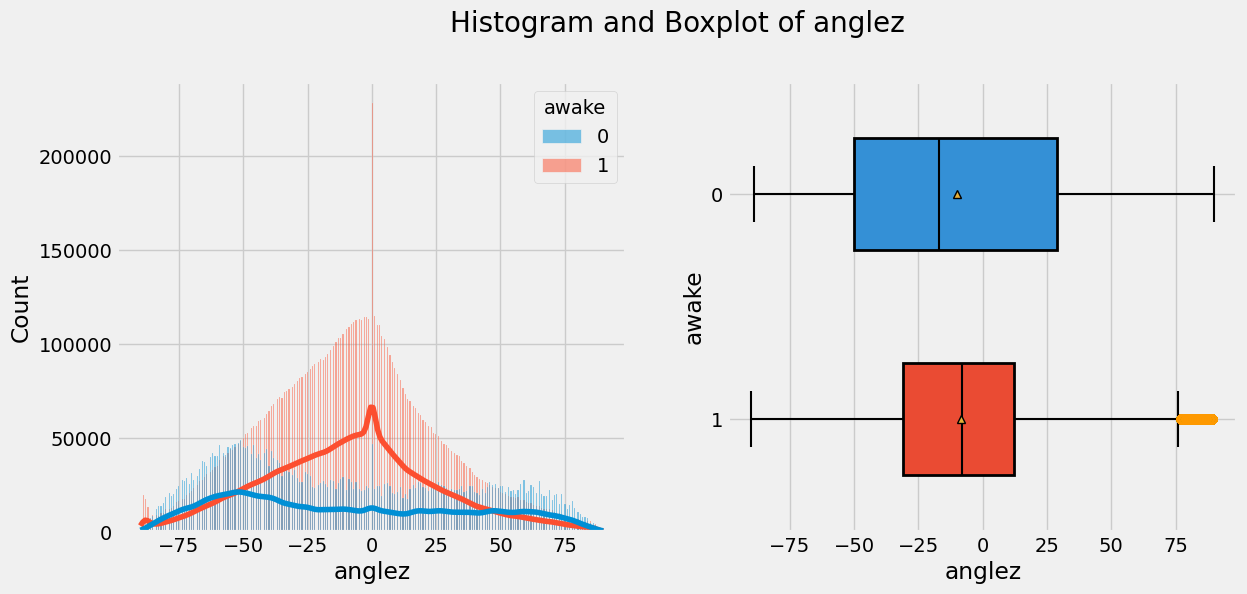

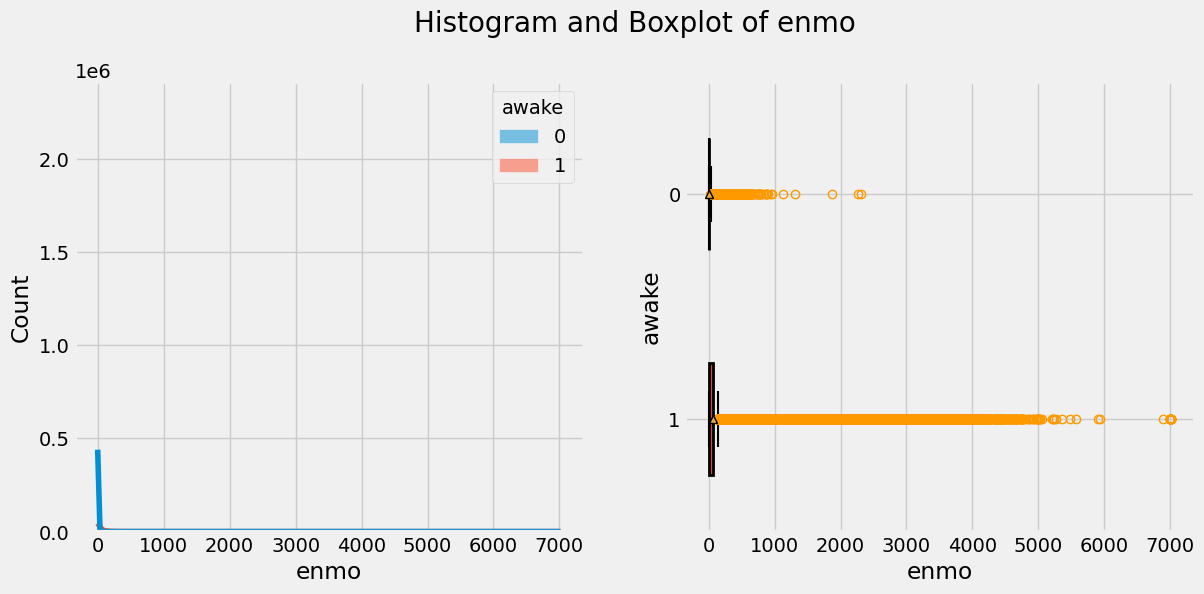

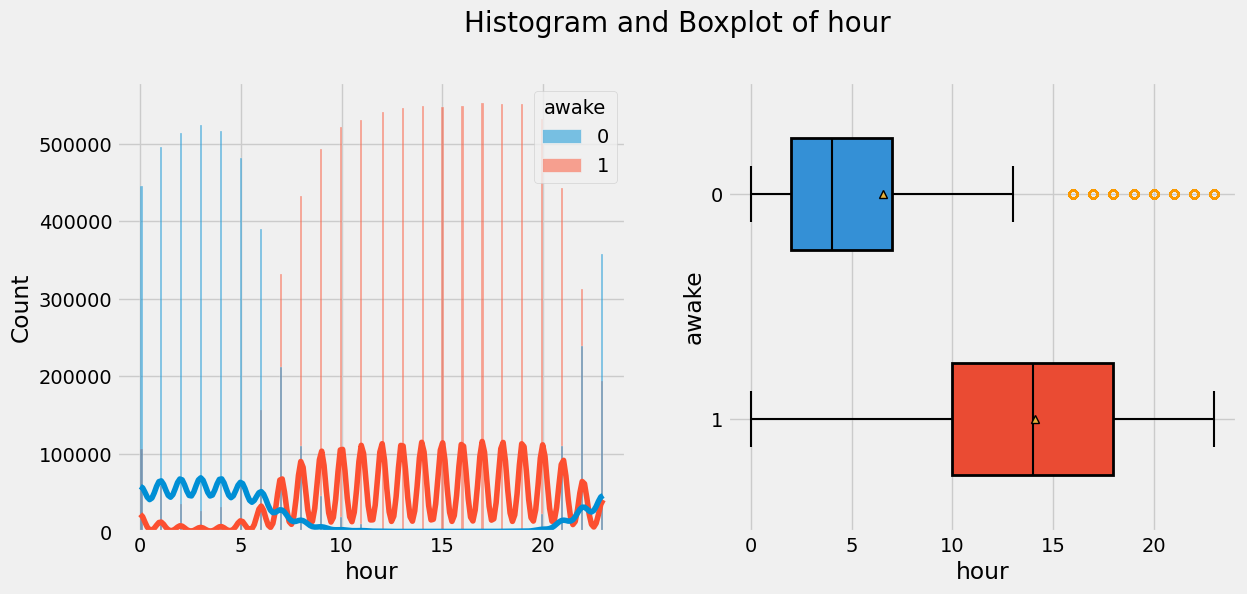

NotImplementedError: float16 indexes are not supported

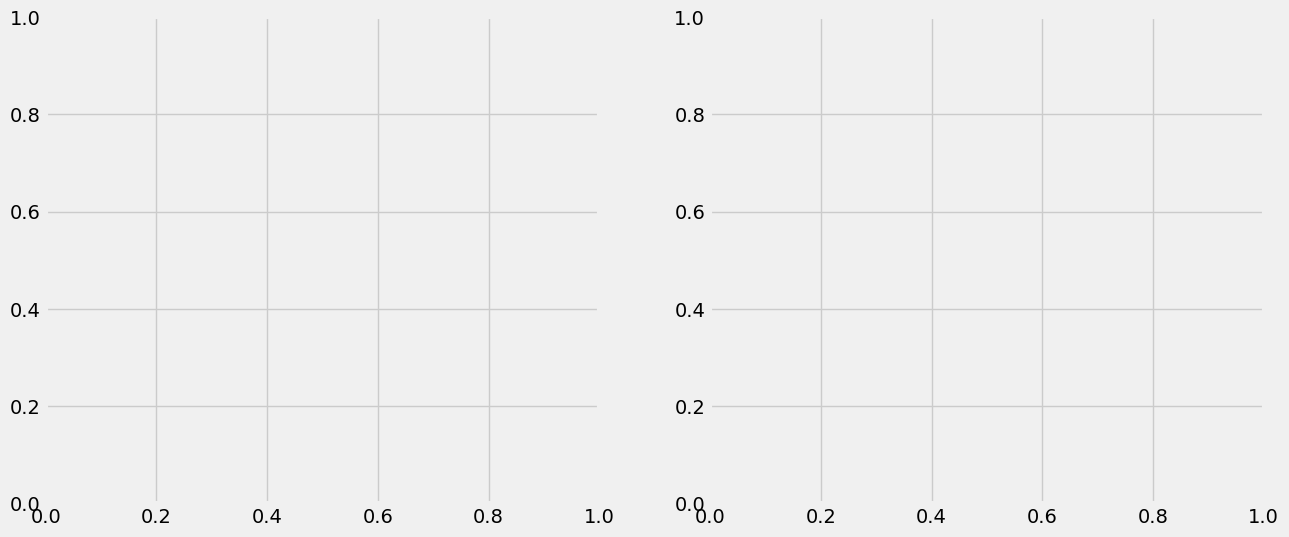

In [14]:
fast_eda(df.drop(['series_id','timestamp'],axis=1),target='awake')

In [ ]:
fast_eda(fast_eda(train_data.drop(['series_id','timestamp'],axis=1)),target='awake')

In [ ]:
pip install sweetviz

In [ ]:
import sweetviz as sv
import pandas as pd

In [ ]:
report = sv.analyze(train_data,target_feat='awake')
report.show_html()

In [ ]:
import os
os.listdir()


In [ ]:
pip install dtale

In [ ]:
import pandas as pd
import dtale

dtale.show(train_data)

In [ ]:
import csv

In [ ]:
pip install ydata-profiling

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp']).apply(lambda t: t.tz_localize(None))

In [ ]:
train_data[train_data['series_id']==train_data['series_id'][0]]

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['timestamp'].dt.time, y='anglez', hue='awake', data=train_data[train_data['series_id']==train_data['series_id'][0]], palette={0: 'red', 1: 'green'}, s=100)

In [ ]:
sns.scatterplot(train_data,x='anglez',y='enmo',hue='awake')

In [ ]:
sns.scatterplot(train_data.iloc[::120],x='anglez',y='enmo',hue='awake')